In this script, we demonstrate an example of what happens when we do not include a necessary transformation in TFP.

In [23]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors

In [24]:
alpha_prior, beta_prior = 4, 3
prior_dist = tfd.Beta(alpha_prior, beta_prior)

conditioned_log_prob = lambda z: prior_dist.log_prob(z)
tf.random.set_seed(20)

def make_surr_approx(loc, scale):
    return tfd.Normal(
        loc = tf.Variable(loc),
        scale = tf.Variable(scale)
    )

def run_fit(surr_post, num_steps):
    return tfp.vi.fit_surrogate_posterior(
        conditioned_log_prob,
        surrogate_posterior = surr_post,
        optimizer = tf.optimizers.Adam(learning_rate=0.05),
        num_steps = num_steps,
        sample_size = 100
    )

surr_50 = make_surr_approx(0.5, 0.25)
surr_10 = make_surr_approx(0.5, 0.25)
surr_20k = make_surr_approx(0.5, 0.25)
surr_100k = make_surr_approx(0.5, 0.25)

losses_10 = run_fit(surr_10, 10)
losses_50 = run_fit(surr_50, 50)
losses_20k = run_fit(surr_20k, 20_000)
losses_100k = run_fit(surr_100k, 100_000)

x = np.linspace(-1, 2, 500)
pdf_fitted_10 = tfd.Normal(surr_10.loc.numpy(), surr_10.scale.numpy()).prob(x)
pdf_fitted_50 = tfd.Normal(surr_50.loc.numpy(), surr_50.scale.numpy()).prob(x)
pdf_fitted_20k = tfd.Normal(surr_20k.loc.numpy(), surr_20k.scale.numpy()).prob(x)
pdf_fitted_100k = tfd.Normal(surr_100k.loc.numpy(), surr_100k.scale.numpy()).prob(x)
pdf_prior = prior_dist.prob(x)

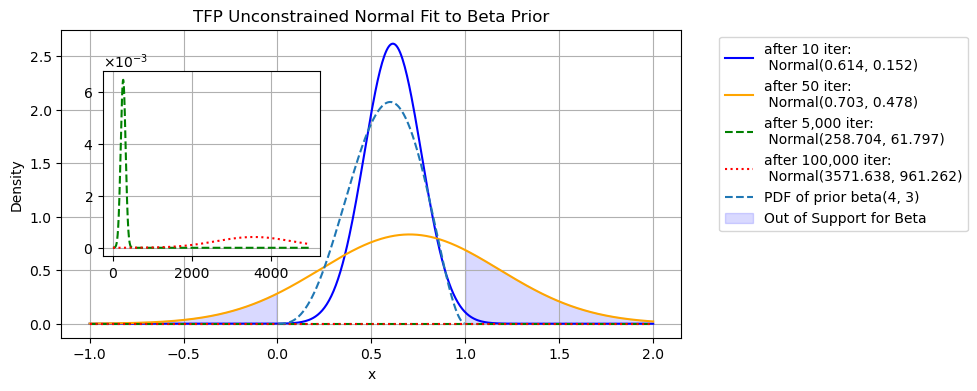

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(8, 4))

# ---- main plot
ax.plot(x, pdf_fitted_10,
        label=f'after 10 iter:\n Normal({surr_10.loc.numpy():.3f},{surr_10.scale.numpy():.3f})',
        color='blue')
ax.plot(x, pdf_fitted_50, 
        label=f'after 50 iter:\n Normal({surr_50.loc.numpy():.3f}, {surr_50.scale.numpy():.3f})',
        color='orange')
ax.plot(x, pdf_fitted_20k,
        label=f'after 5,000 iter:\n Normal({surr_20k.loc.numpy():.3f}, {surr_20k.scale.numpy():.3f})',
        ls='--', color='green')
ax.plot(x, pdf_fitted_100k,
        label=f'after 100,000 iter:\n Normal({surr_100k.loc.numpy():.3f}, {surr_100k.scale.numpy():.3f})',
        ls=':', color='red')
ax.plot(x, pdf_prior, '--',
        label=f'PDF of prior beta({alpha_prior}, {beta_prior})')

ax.fill_between(
    x, 0, pdf_fitted_50,
    where=(x < 0) | (x > 1),
    color='blue', alpha=0.15,
    label='Out of Support for Beta'
)

ax.set_title('TFP Unconstrained Normal Fit to Beta Prior')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ---- inset axes (upper left)
axins = inset_axes(ax, width="35%", height="60%", loc="upper left", borderpad=3.0)
inset_x = np.linspace(-1, 5000, 2000)

axins.plot(inset_x, tfd.Normal(surr_20k.loc.numpy(), surr_20k.scale.numpy()).prob(inset_x), color='green', ls='--')
axins.plot(inset_x, tfd.Normal(surr_100k.loc.numpy(), surr_100k.scale.numpy()).prob(inset_x), color='red', ls=':')
axins.grid(True)

from matplotlib.ticker import ScalarFormatter

# scientific notation for inset y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))  # always use scientific notation

axins.yaxis.set_major_formatter(formatter)
# axins.set_yticks([0.0, 5e-5, 1e-4, 1.5e-4, 2e-4])
# axins.tick_params(labelsize=8)
# axins.yaxis.get_offset_text().set_size(8)
plt.show()


What happens when we tell TFP to use a transformation?

In [27]:
def make_sigmoid_surr_approx(loc, scale):
    return tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=(),
        bijector=tfb.Sigmoid(),
        initial_parameters={'loc': loc,'scale': scale}
    )

transformed_surr_10 =  make_sigmoid_surr_approx(0.5, 0.25)
transformed_surr_50 = make_sigmoid_surr_approx(0.5, 0.25)
transformed_surr_20k = make_sigmoid_surr_approx(0.5, 0.25)
transformed_surr_100k = make_sigmoid_surr_approx(0.5, 0.25)

transformed_losses_10 = run_fit(transformed_surr_10, 10)
transformed_losses_50 = run_fit(transformed_surr_50, 50)
transformed_losses_20k = run_fit(transformed_surr_20k, 20_000)
transformed_losses_100k = run_fit(transformed_surr_100k, 100_000)

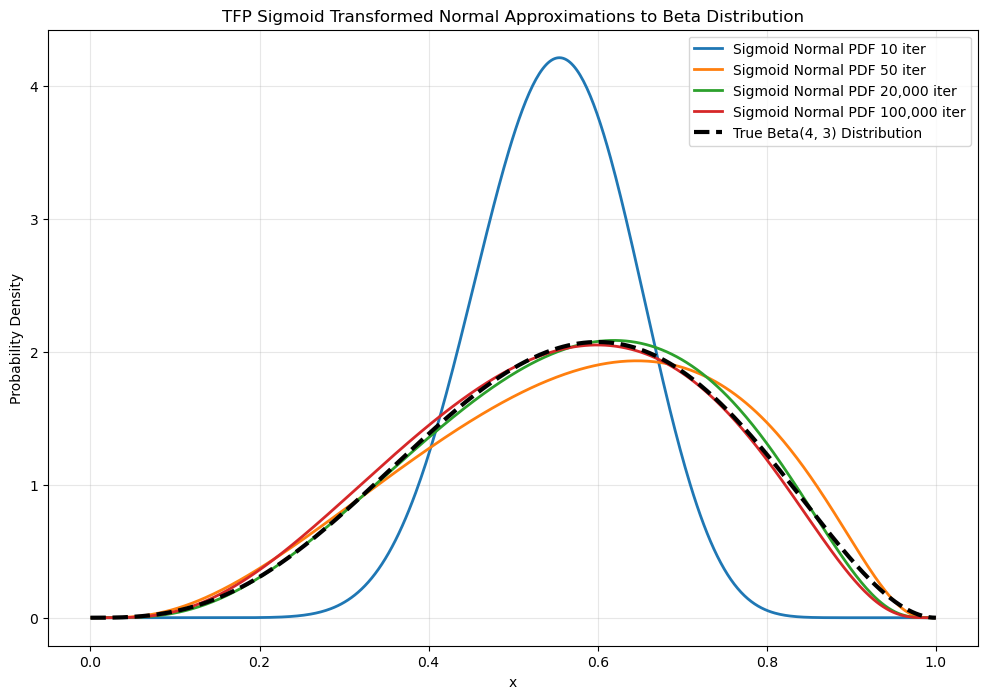

In [28]:
plt.figure(figsize=(12, 8))
x = np.linspace(0, 1, 500)  
plt.plot(x, transformed_surr_10.prob(x).numpy(), label=f'Sigmoid Normal PDF 10 iter', linewidth=2)
plt.plot(x, transformed_surr_50.prob(x).numpy(), label=f'Sigmoid Normal PDF 50 iter', linewidth=2)
plt.plot(x, transformed_surr_20k.prob(x).numpy(), label=f'Sigmoid Normal PDF 20,000 iter', linewidth=2)
plt.plot(x, transformed_surr_100k.prob(x).numpy(), label=f'Sigmoid Normal PDF 100,000 iter', linewidth=2)

# Plot the true Beta distribution we're trying to approximate
true_distribution = prior_dist  
plt.plot(x, true_distribution.prob(x).numpy(), '--', label=f'True Beta({alpha_prior}, {beta_prior}) Distribution', linewidth=3, color='black')

plt.title('TFP Sigmoid Transformed Normal Approximations to Beta Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
